#  Core Sequence-Aware Agent Design v2

This experiment explores a transformer-based recurrent PPO agent for financial trading. The environment is sequence-aware and includes both regime-based augmentation and per-episode reward normalization. The agent is evaluated across top 2 stocks in each sector using structured episode sequences to assess learning generalization.

---

##  Experiment Configuration

| Parameter               | Value                         |
|-------------------------|-------------------------------|
| Agent                   | Recurrent PPO + Transformer   |
| Env Wrapper             | RegimeAugmentingWrapper + PerEpisodeRewardNormalizer |
| Episode Length          | 100                           |
| Episodes                | 20                            |
| Eval Episodes           | 3 per iteration               |
| Steps per Update        | 800                           |
| Batch Size              | 100                           |
| Total Timesteps         | 20,000                        |
| Learning Rate           | 0.0003                        |
| Entropy Coefficient     | 0.005                         |
| Value Function Coeff    | 0.5                           |
| Max Gradient Norm       | 0.5                           |
| Normalize Advantage     | True                          |
| Optimizer               | Adam                          |
| Transformer d_model     | 64                            |
| Heads                  | 4                             |
| Layers                 | 2                             |

---

## Environment Setup

- **Train Set:** 2023-01-01 → 2023-07-01
- **Test Set:** 2023-07-01 → 2024-01-01
- **Assets:** Top 2 stocks by sector
- **Sequence Split:** 80% train / 20% eval sequences

---

##  Agent Architecture

- **Feature Extractor:** Transformer encoder with causal mask and learnable positional encoding.
- **Policy Class:** Custom `TransformerPolicy` extending `RecurrentActorCriticPolicy`.
- **Reward Normalization:** Online normalization within episodes.
- **Regime Augmentation:** Appends one-hot encoded market regime to each timestep.

---

## Training Summary (Selected Stats)

| Timesteps | Ep Rew Mean | Explained Variance | Value Loss | Policy Grad Loss |
|-----------|-------------|--------------------|------------|------------------|
|  8000     | 3.21        | 0.15               | 4.68       | -0.00277         |
| 14400     | 2.90        | 0.645              | 1.71       |  0.00163         |
| 20000     | **3.79**    | **0.751**          | 1.59       | -0.00012         |

---

## Evaluation Snapshots

| Timestep | Mean Reward | Std Dev | Eval Length |
|----------|-------------|---------|-------------|
| 5000     | -8.17       | ±8.72   | 102         |
| 10000    | -4.43       | ±7.59   | 102         |
| 15000    | -6.17       | ±4.92   | 102         |
| 20000    | **0.24**    | ±2.86   | 102         |

---

## Statistical Significance

### Paired t-test and Mann-Whitney U-test

| Metric       | t-test p-value | Mann-Whitney p-value |
|--------------|----------------|-----------------------|
| `total_reward` | 0.0300         | 0.0075                |
| `calmar`       | 0.0132         | 0.0075                |

✅ Both `total_reward` and `calmar ratio` show **statistically significant** improvements compared to the baseline.  
Especially, Calmar implies **more stable and risk-adjusted returns**.

> Note: `sharpe`, `sortino`, and `final_wealth` were skipped due to empty values in the evaluation logs. Ensure metrics are logged and valid across all test episodes to include them.

---

## Next Steps

1. **Fix missing metrics** (`sharpe`, `sortino`, etc.) in the logging pipeline.
2. **Plot distribution comparisons** (boxplots, histograms) for rewards and risk-adjusted returns.
3. **Run ablation**:
   - Without regime augmentation
   - Without reward normalization
   - With simpler agents (e.g., MLP or LSTM)
4. **Test in unseen market conditions** or during volatility spikes to check robustness.

---

_Logged using `ExperimentTracker` — Run Hash: `${experiment_tracker.run_hash}`_


In [1]:
# SETUP ===================================
import jupyter
import warnings

from src.utils.system import boot, Notify

boot()
warnings.filterwarnings("ignore")



# PACKAGES ================================
import os
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import  RobustScaler

# FRAMEWORK STUFF =========================
from src.defaults import TOP2_STOCK_BY_SECTOR, FEATURE_COLS,EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
from src.experiments.experiment_tracker import ExperimentTracker
from src.env.base_timeseries_trading_env import BaseSequenceAwareTradingEnv,SequenceAwareAlphaTradingEnv,SequenceAwareBaselineTradingAgent,SequenceAwareCalmarTradingEnv,SequenceAwareCumulativeTradingEnv,SequenceAwareDrawdownTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareSharpeTradingEnv,SequenceAwareSortinoTradingEnv

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy



In [2]:

# ========== CONFIG ==========
EXPERIENCE_NAME = "core_sequence_aware_agent_design_v2"
RESULTS_PATH = f"data/experiments/{EXPERIENCE_NAME}_barebones_results.csv"
N_EPISODES = 20
N_SEEDS = 3
N_EVAL_EPISODES = 3

WINDOW_LENGTH = 10  
TOTAL_TIMESTEPS = EPISODE_LENGTH * 150
N_STEPS = EPISODE_LENGTH * 2

TRANSACTION_COST = 0

CONFIG = {
    "batch_size": EPISODE_LENGTH,
    "n_steps": 800,
    "total_timesteps": TOTAL_TIMESTEPS,
    "project_name":EXPERIENCE_NAME
}




# Load data ==================================
ohlcv_df = load_base_dataframe()

# Experiment tracker ========================= 
experiment_tracker = ExperimentTracker(EXPERIENCE_NAME)
experiment_tracker.set_hash(CONFIG)

# Files ======================================
checkpoint_path = "data/checkpoint" 
checkpoint_name = "-8377624099423380081"#experiment_tracker.run_hash
checkpoint_preffix = f"{checkpoint_name}--checkpoint"
checkpoint_best_model=f"{checkpoint_path}/{checkpoint_name}--best_model"
log_path="data/logs"
save_path= f"{checkpoint_path}/{checkpoint_name}--final"
print(checkpoint_name)
#data/checkpoint/-8377624099423380081--final
#data/checkpoint/-3848392742194634112--best_model

-8377624099423380081


In [3]:
EPISODE_LENGTH = 100
MAX_LENGTH = 200
SAVE_FREQ=10000
EVAL_FREQ=5000
TOTAL_TIMESTEPS=200000
#TOTAL_TIMESTEPS=1000
EPISODES_PER_UPDATE = 8          # ~how many episodes before PPO updates
EPISODES_PER_BATCH = 1           # number of full episodes per batch

# === Auto-derive PPO settings ===
N_STEPS = EPISODE_LENGTH * EPISODES_PER_UPDATE
BATCH_SIZE = EPISODE_LENGTH * EPISODES_PER_BATCH

ENV_CLASS = SequenceAwareCumulativeTradingEnv

n = Notify(experiment_tracker.project)
n.info('START')
print(N_STEPS,BATCH_SIZE)

800 100


In [4]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# Causal Mask Function ============================
def generate_causal_mask(seq_len):
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

# Transformer Feature Extractor ===================
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, n_heads=4, n_layers=2, max_len=MAX_LENGTH):
        super().__init__(observation_space, features_dim=d_model)
        self.d_model = d_model
        input_dim = observation_space.shape[-1]

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward_v1(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]
        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)
        return x[:, -1]  # return the last token output
    
    def forward(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        #print(">>> [Transformer] Input shape:", obs.shape)

        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]

        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)

        pooled_output = x[:, -1]
        #print(">>> [Transformer] Pooled output mean/std:", pooled_output.mean().item(), pooled_output.std().item())

        return pooled_output

# Transformer Policy ===================================
class TransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs,
                         features_extractor_class=TransformerFeatureExtractor,
                         features_extractor_kwargs=dict(
                             d_model=64, n_heads=4, n_layers=2, max_len=32
                         ))
        #self._build(self.lr_schedule)

# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # 0,1,2 -> bull,bear,sideways
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

class PerEpisodeRewardNormalizer(gym.Wrapper):
    def reset(self, **kwargs):
        self.episode_rewards = []
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_rewards.append(reward)
        mean = np.mean(self.episode_rewards)
        std = np.std(self.episode_rewards) + 1e-8
        norm_reward = (reward - mean) / std
        return obs, norm_reward, done, truncated, info
# Training =============================================================
train_df = ohlcv_df[(ohlcv_df['date']>="2023-01-01") & (ohlcv_df['date']<"2023-07-01")]
test_df = ohlcv_df[(ohlcv_df['date']>="2023-07-01") & (ohlcv_df['date']<"2024-01-01")]
train_df = train_df[train_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]

train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
test_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
# Train on few episodes to prove a point only
train_seq = train_env.generate_episode_sequences(TOTAL_TIMESTEPS)
_test_seq = test_env.generate_episode_sequences(int(TOTAL_TIMESTEPS))
episodes = _test_seq
unique_episodes = {}
for ticker, start in episodes:
    if ticker not in unique_episodes:
        unique_episodes[ticker] = start
# Convert back to a list of tuples
test_seq = [(ticker, start) for ticker, start in unique_episodes.items()]

print(f"Training on {len(train_seq)} different episodes accross the top 2 stocks for each sector")
print(f"Testing on {len(test_seq)} different episodes accross the top 2 stocks for each sector")
def train_agent():
    
    
    
    train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    train_env.set_episode_sequence(train_seq)
    eval_env.set_episode_sequence(test_seq)
    
    train_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(train_env))
    eval_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env))
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ, save_path=checkpoint_path, name_prefix=checkpoint_preffix
    )

    eval_callback = EvalCallback(
        eval_env, best_model_save_path=checkpoint_best_model,
        log_path=log_path, eval_freq=EVAL_FREQ, deterministic=True
    )

    model = RecurrentPPO(
        policy=TransformerPolicy,
        env=train_env,
        verbose=1,
        #tensorboard_log="./tensorboard_logs",
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.005,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        policy_kwargs=dict(share_features_extractor=True)
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback, eval_callback])
    model.save(save_path)

#if __name__ == "__main__":
#    train_agent()


Training on 1961 different episodes accross the top 2 stocks for each sector
Testing on 22 different episodes accross the top 2 stocks for each sector


In [5]:
n = Notify(experiment_tracker.project)
n.info('DONE')

In [59]:
import random
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces


from src.env.step_rewards import reward_sharpe,reward_sortino,reward_drawdown,reward_alpha,reward_cumulative,reward_calmar,reward_hybrid

class BaseSequenceAwareTradingEnv(gym.Env):
    """
    Flexible RL Trading Env with windowed sequence obs (Transformer/LSTM/MLP-ready).
    - Set `return_sequences=True` for (window_length, obs_dim) obs (for transformers).
    - Set `return_sequences=False` for flat obs (classic RL, SB3 LSTM/MLP).
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self, df, feature_cols=None, reward_fn=None, internal_features=None,
        episode_length=100, transaction_cost=0.0001, seed=314, window_length=10, return_sequences=True):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or []
        self.internal_features = internal_features or [
            "position", "holding_period", "cumulative_reward", "pct_time",
            "drawdown", "rel_perf", "unrealized_pnl", "entry_price", "time_in_position"
        ]
        self.obs_dim = len(self.feature_cols) + len(self.internal_features)
        self.episode_length = episode_length +2
        self.window_length = max(1, window_length)
        self.return_sequences = return_sequences  # True: (window, obs_dim), False: flat
        self.transaction_cost = transaction_cost
        self.seed = seed
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if seed is not None:
            np.random.seed(seed)
        counts = df['symbol'].value_counts()
        eligible = counts[counts >= episode_length].index
        self.stocks = df[df['symbol'].isin(eligible)]['symbol'].unique()
        self.episode_df = df.copy()
        self.reward_fn = reward_fn or self.default_reward_fn

        # Set observation space
        if self.return_sequences:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length, self.obs_dim), dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length * self.obs_dim,), dtype=np.float32
            )
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell

    
    def get_current_regime(self):
        """
        Detects current regime based on recent return volatility and trend.
        Returns:
            0 = Bull, 1 = Bear, 2 = Sideways
        """
        if self.current_step < self.window_length:
            return 2  # Not enough data, assume sideways

        # Use recent price changes to detect regime
        returns = self.episode_df['return_1d'].iloc[self.current_step - self.window_length:self.current_step].values
        mean_return = returns.mean()
        std_return = returns.std()

        # Thresholds can be tuned
        if mean_return > 0.001 and std_return < 0.01:
            return 0  # Bull
        elif mean_return < -0.001 and std_return < 0.01:
            return 1  # Bear
        else:
            return 2  # Sideways
        
    def default_reward_fn(self, position, price_change, **kwargs):
        return position * price_change

    def set_episode_sequence(self, sequence):
        self.episode_sequence = sequence
        self.episode_counter = 0

    def generate_episode_sequences_v1(self, train_steps=10000):
        dataset_length = len(self.df)
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        ticker = self.df['symbol'].unique()[0]
        min_start = 0
        max_start = dataset_length - self.episode_length - 2
        for i in range(episodes):
            episode_sequences.append((ticker, np.random.randint(0, max_start)))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def generate_episode_sequences(self, train_steps=10000):
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        for _ in range(episodes):
            ticker = np.random.choice(self.stocks)
            stock_df = self.df[self.df['symbol'] == ticker].reset_index(drop=True)
            max_start = len(stock_df) - self.episode_length - 2
            if max_start <= 0:
                continue  # skip if not enough data
            start = np.random.randint(0, max_start)
            episode_sequences.append((ticker, start))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def reset(self, seed=None, options=None, start_index=None):
        self.entry_step = None
        self.unrealized_pnl = 0
        self.relative_perf = 0
        self.drawdown = 0
        self.time_in_position = 0
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if self.seed is not None:
            np.random.seed(self.seed)

        for _ in range(10):  # Try up to 10 times to get a valid episode
            stock = self.stocks[0]
            if hasattr(self, "episode_sequence"):
                if self.episode_counter >= len(self.episode_sequence):
                    self.episode_counter = 0
                _, start = self.episode_sequence[self.episode_counter]
                self.episode_counter += 1
            else:
                stock = np.random.choice(self.stocks)
                stock_df = self.df[self.df['symbol'] == stock].reset_index(drop=True)
                max_start = len(stock_df) - self.episode_length
                if max_start <= 0:
                    continue  # Try another stock
                start = np.random.randint(0, max_start + 1)

            self.stock = stock
            stock_df = self.df[self.df['symbol'] == self.stock].reset_index(drop=True)
            self.episode_df = stock_df.iloc[int(start):int(start) + int(self.episode_length + 2)].reset_index(drop=True)

            if len(self.episode_df) >= self.window_length:
                break
        else:
            raise RuntimeError("Failed to sample a valid episode with sufficient data.")

        self.current_step = 0
        self.entry_price = None
        self.position = 0
        self.holding_period = 0
        self.cumulative_reward = 0
        self.returns_history = []
        self.reward_history = []
        self.episode_pct_changes = self.episode_df['return_1d'].values
        self.max_possible_reward = np.sum(np.abs(self.episode_pct_changes))
        self.current_wealth = 1.0
        self.peak_wealth = 1.0

        return self._get_obs(), {}

    def _get_obs(self):
        # Returns a rolling window of observations (2D or flattened)
        obs_list = []
        for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
            idx = max(i, 0)  # pad with earliest available step
            features = self.episode_df.iloc[idx][self.feature_cols].values.astype(np.float32)
            internal_state = {
                "position": self.position,
                "holding_period": self.holding_period,
                "cumulative_reward": self.cumulative_reward,
                "pct_time": idx / self.episode_length,
                "drawdown": self.drawdown,
                "rel_perf": self.relative_perf,
                "unrealized_pnl": self.unrealized_pnl,
                "entry_price": self.entry_price if self.entry_price is not None else 0.0,
                "time_in_position": self.time_in_position,
            }
            internal = np.array([internal_state[name] for name in self.internal_features], dtype=np.float32)
            obs = np.concatenate([features, internal])
            obs_list.append(obs)
        obs_window = np.stack(obs_list)  # shape: (window_length, obs_dim)
        if self.return_sequences:
            return obs_window  # shape: (window_length, obs_dim)
        else:
            return obs_window.flatten()  # shape: (window_length * obs_dim,)

    def step(self, action):
        # (step code unchanged from your version)
        done = self.current_step >= self.episode_length -1
        current_row = self.episode_df.iloc[self.current_step]
        next_row = self.episode_df.iloc[self.current_step + 1]
        price_change = next_row['return_1d']
        prev_position = self.position
        reward = 0
        cost = 0
        self.action_counts[action] += 1
        if action == 1:  # Buy
            if self.position != 1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = 1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step
        elif action == 2:  # Sell
            if self.position != -1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = -1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        if self.position != 0:
            self.holding_period += 1

        step_return = self.position * price_change
        self.returns_history.append(step_return)
        self.current_wealth *= (1 + step_return)
        if self.current_wealth > self.peak_wealth:
            self.peak_wealth = self.current_wealth
        self.drawdown = 1 - self.current_wealth / self.peak_wealth

        if self.position != 0 and self.entry_price is not None:
            current_price = next_row['close']
            self.unrealized_pnl = (current_price - self.entry_price) * self.position / self.entry_price
            self.time_in_position = self.current_step - self.entry_step
        else:
            self.unrealized_pnl = 0
            self.time_in_position = 0

        if 'market_return_1d' in self.episode_df.columns:
            self.relative_perf = price_change - next_row['market_return_1d']
        else:
            self.relative_perf = 0

        reward = self.reward_fn(
            position=self.position,
            price_change=price_change,
            prev_position=prev_position,
            env=self
        )
        reward -= cost
        self.reward_history.append(reward)
        self.cumulative_reward += reward

        self.current_step += 1
        obs = self._get_obs()
        info = {}
        info["regime"] = self.get_current_regime()
        # --- Robust Metrics Calculation ---
        if done:
            returns = np.array(self.returns_history)
            mean = np.median(returns) if len(returns) > 0 else np.nan
            std = returns.std() if len(returns) > 1 else np.nan
            downside = returns[returns < 0]
            downside_std = downside.std() if len(downside) > 1 else np.nan

            sharpe = mean / std if (std is not None and std > 0 and not np.isnan(std)) else np.nan
            sortino = mean / downside_std if (downside_std is not None and downside_std > 0 and not np.isnan(downside_std)) else np.nan

            wealth_curve = np.cumprod(1 + returns) if len(returns) > 0 else np.array([])
            peak_wealth = np.maximum.accumulate(wealth_curve) if len(wealth_curve) > 0 else np.array([])
            drawdowns = (wealth_curve - peak_wealth) / (peak_wealth + 1e-8) if len(wealth_curve) > 0 else np.array([])
            max_drawdown = np.abs(drawdowns.min()) if len(drawdowns) > 0 else np.nan
            calmar = ((wealth_curve[-1] - 1) / max_drawdown) if (len(wealth_curve) > 0 and max_drawdown and not np.isnan(max_drawdown) and max_drawdown > 0) else np.nan
            cum_return = wealth_curve[-1] - 1 if len(wealth_curve) > 0 else np.nan


            final_wealth = wealth_curve[-1] if len(wealth_curve) > 0 else np.nan



            trades = []
            trade_profits = []
            prev = 0
            for i, ret in enumerate(returns):
                if prev == 0 and ret != 0:
                    entry_idx = i
                    entry_dir = np.sign(ret)
                elif prev != 0 and (ret == 0 or np.sign(ret) != np.sign(prev)):
                    if 'entry_idx' in locals():
                        trade = returns[entry_idx:i+1]
                        trade_profits.append(np.sum(trade))
                        del entry_idx
                prev = ret
            win_rate = np.median(np.array(trade_profits) > 0) if trade_profits else np.nan

            if 'market_return_1d' in self.episode_df.columns:
                market_returns = self.episode_df['market_return_1d'].values[1:self.episode_length]
                market_wealth_curve = np.cumprod(1 + market_returns) if len(market_returns) > 0 else np.array([])
                market_cum_return = market_wealth_curve[-1] - 1 if len(market_wealth_curve) > 0 else np.nan
                alpha = cum_return - market_cum_return if cum_return is not None and not np.isnan(cum_return) and market_cum_return is not None and not np.isnan(market_cum_return) else np.nan
            else:
                alpha = np.nan

            info.update({
                "episode_sharpe": sharpe,
                "episode_sortino": sortino,
                "episode_total_reward": np.sum(self.reward_history) if len(self.reward_history) > 0 else np.nan,
                "cumulative_return": cum_return,
                "calmar": calmar,
                "max_drawdown": max_drawdown,
                "win_rate": win_rate,
                "alpha": alpha,
                "returns": returns,
                "market_returns":market_returns,
                "downside": downside,
                "regime": self.get_current_regime(),
                "final_wealth": final_wealth,
                "action_hold_count": self.action_counts[0],
                "action_buy_count": self.action_counts[1],
                "action_sell_count": self.action_counts[2],
                #"cumulative_return": final_wealth - 1 if not np.isnan(final_wealth) else np.nan
            })


        # (metrics code unchanged, same as your original step)

        return obs, reward, done, False, info

    def render(self):
        print(f"Step: {self.current_step} | Pos: {self.position} | Hold: {self.holding_period} | CumRew: {self.cumulative_reward:.4f}")



class SequenceAwareSharpeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sharpe, **kwargs)

class SequenceAwareSortinoTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sortino, **kwargs)

class SequenceAwareAlphaTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_alpha, **kwargs)

class SequenceAwareDrawdownTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_drawdown, **kwargs)

class SequenceAwareCumulativeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_cumulative, **kwargs)

class SequenceAwareCalmarTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_calmar, **kwargs)

class SequenceAwareHybridTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_hybrid, **kwargs)

class SequenceAwareBaselineTradingAgent:
    def __init__(self,df,feature_cols=[],
            episode_length=100, seed=314,set_episode_sequence=[]):
    
        self.env = BaseSequenceAwareTradingEnv(df, feature_cols=feature_cols,
            episode_length=episode_length, seed=seed)
        self.env.set_episode_sequence(set_episode_sequence)
        
    def predict(self,obs,*args,**kwargs):
        #print(self.env.stocks,'xxxxxxxxxxx')
        return self.env.action_space.sample(),{}
    
    def set_episode_sequence(self,seq):
        
        pass

    
    
# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # should return 0, 1, or 2
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

Evaluating Agent: 100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


>>> [Eval] Action counts: Series([], Name: count, dtype: int64)


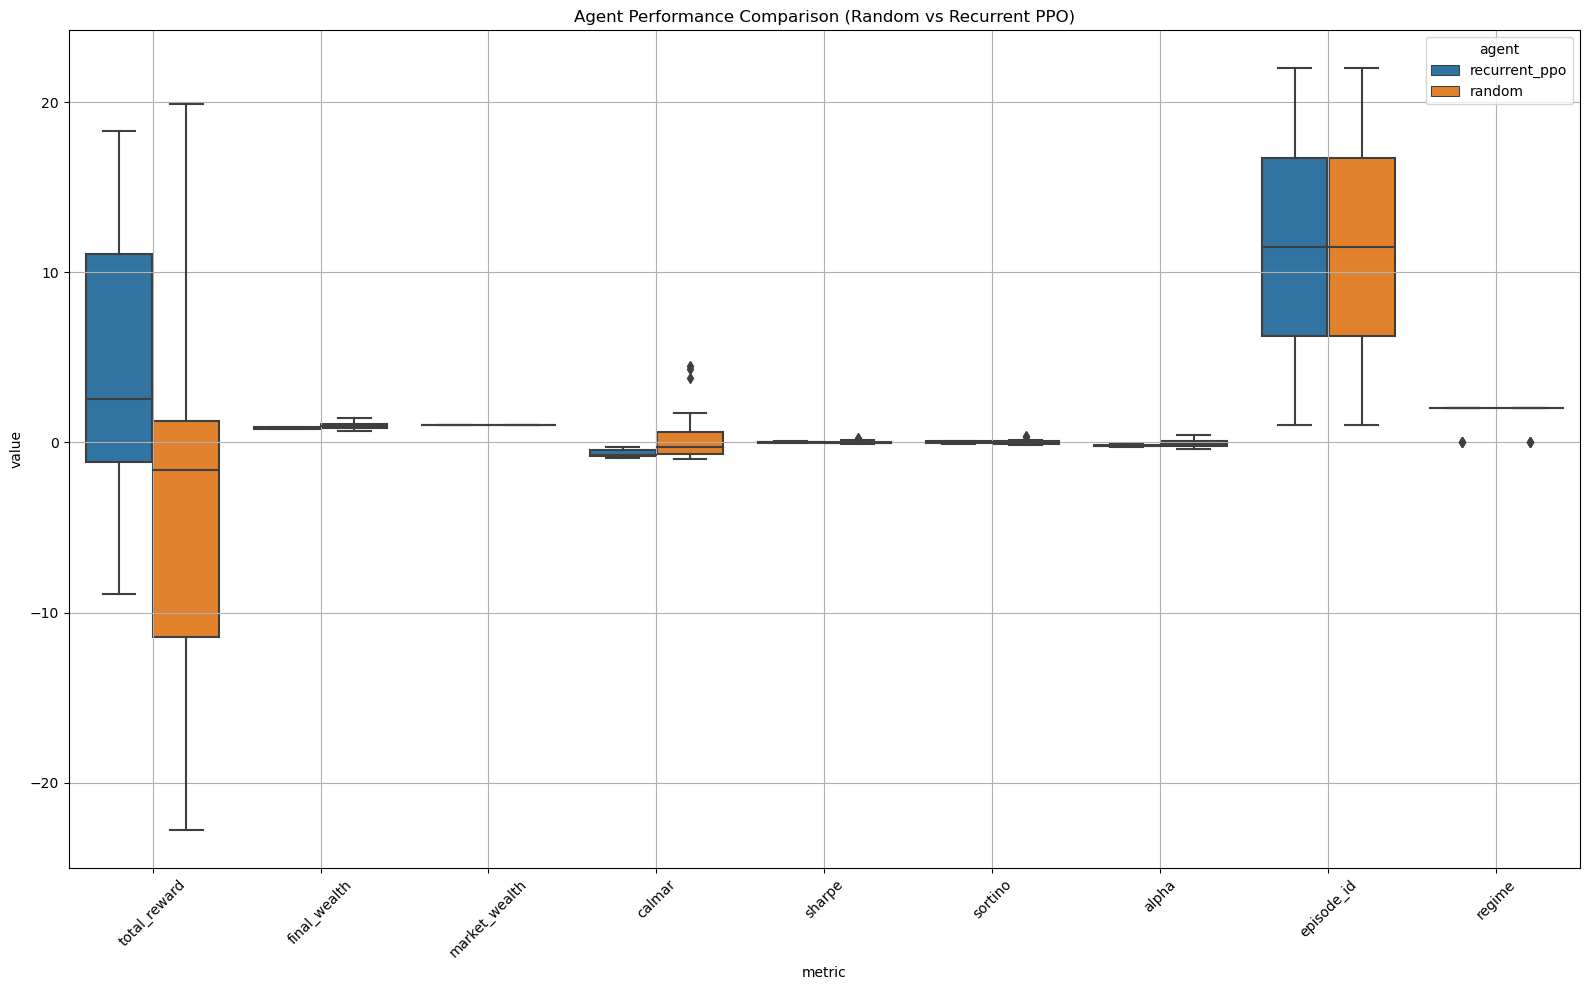

,metric,t-test p-value,mann-whitney p-value
0,total_reward,0.014269,0.012376
1,final_wealth,0.003245,0.005787
2,market_wealth,1.000000,1.000000
3,calmar,0.006143,0.006675
4,sharpe,0.939199,0.285247
5,sortino,0.652002,0.698374
6,alpha,0.003324,0.009454
7,episode_id,1.000000,1.000000
8,regime,1.000000,1.000000


In [92]:
# === Imports ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_ind, mannwhitneyu

from sb3_contrib import RecurrentPPO
#from src.env.base_timeseries_trading_env import SequenceAwareCumulativeTradingEnv
from src.defaults import TOP2_STOCK_BY_SECTOR, EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
#from src.env.base_timeseries_trading_env import RegimeAugmentingWrapper

ENV_CLASS=SequenceAwareCumulativeTradingEnv
# === Config ===
N_EVAL_EPISODES = 5
MODEL_PATH = save_path

# === Load Data ===
ohlcv_df = load_base_dataframe()
test_df = ohlcv_df[(ohlcv_df['date'] >= "2023-07-01") & (ohlcv_df['date'] < "2024-01-01")]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]


# === Evaluation Logic ===
def evaluate_agent(agent, env, n_episodes=22):
    episode_metrics = []
    action_counts = []
    episode_infos=[]


    for _ in tqdm(range(n_episodes), desc="Evaluating Agent"):
        obs, _ = env.reset()
        #print(">>> [Eval] Obs shape:", obs.shape)  # Check input dimensions

        done = False
        state = None
        rewards = []
        infos = []

        while not done:
            action, state = agent.predict(obs, state=state, deterministic=True)
            #print(action)
            #print(env.action_counts)
            action = int(action)
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)

        _env = env.env.env
        
        agent_wealth = infos[-1].get("final_wealth", np.nan)         # Your agent
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)       # Market index
        alpha = agent_wealth - market_wealth              # Skill
        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": infos[-1].get("final_wealth", np.nan),
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha":alpha,
            "episode_id": env.env.env.episode_counter,
            "regime": infos[-1].get("regime",np.nan)
        }
        info["ticker"]=env.env.env.episode_df.iloc[0]['symbol']
        info["tickers"]=env.env.env.episode_df['symbol'].unique()
        episode_infos.append(info)
        episode_metrics.append(metrics)
    
    print(">>> [Eval] Action counts:", pd.Series(action_counts).value_counts())
    return pd.DataFrame(episode_metrics), episode_infos


def evaluate_random_agent(env, n_episodes=22):
    episode_metrics = []
    episode_infos = []
    for i in tqdm(range(n_episodes), desc="Evaluating Random Agent"):
        obs, _ = env.reset()
        done = False
        rewards = []
        infos = []

        while not done:
            action = env.action_space.sample()
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)

        _env = env.env.env
        
        agent_wealth = infos[-1].get("final_wealth", np.nan)         # Your agent
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)       # Market index
        alpha = agent_wealth - market_wealth              # Skill
        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": infos[-1].get("final_wealth", np.nan),
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha":alpha,
            "episode_id": env.env.env.episode_counter,
            "regime": infos[-1].get("regime",np.nan),
       
        }
        info["ticker"]=env.env.env.episode_df.iloc[0]['symbol']
        info["tickers"]=env.env.env.episode_df['symbol'].unique()
        episode_metrics.append(metrics)
        episode_infos.append(info)
    return pd.DataFrame(episode_metrics), episode_infos


# === Run Evaluation ===

model = RecurrentPPO.load(MODEL_PATH)

def make_test_env():
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env.set_episode_sequence(test_seq)
    return PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env)) #RegimeAugmentingWrapper(ENV_CLASS(test_df, episode_length=EPISODE_LENGTH,feature_cols=FEATURE_COLS))

random_agent_df, random_agent_infos = evaluate_random_agent(make_test_env(), n_episodes=22)
ppo_agent_df, ppo_agent_infos = evaluate_agent(model, make_test_env(), n_episodes=22)


ppo_agent_df["agent"] = "recurrent_ppo"
random_agent_df["agent"] = "random"
results_df = pd.concat([ppo_agent_df, random_agent_df])


# === Plotting ===
melted = results_df.melt(id_vars="agent", var_name="metric", value_name="value")
plt.figure(figsize=(16, 10))
sns.boxplot(data=melted, x="metric", y="value", hue="agent")
plt.title("Agent Performance Comparison (Random vs Recurrent PPO)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# === Statistical Tests ===
comparison_results = []

for metric in ppo_agent_df.columns[:-1]:  # exclude 'agent'
    a = ppo_agent_df[metric].dropna()
    b = random_agent_df[metric].dropna()

    # Skip if either is empty
    if len(a) == 0 or len(b) == 0:
        print(f"Skipping metric {metric}: empty values")
        continue

    t_stat, p_val_t = ttest_ind(a, b)
    u_stat, p_val_u = mannwhitneyu(a, b, alternative='two-sided')
    comparison_results.append({
        "metric": metric,
        "t-test p-value": p_val_t,
        "mann-whitney p-value": p_val_u
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df



<Axes: xlabel='market_wealth', ylabel='alpha'>

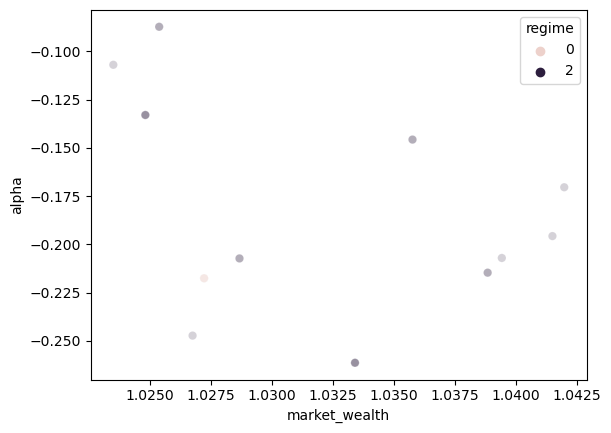

In [94]:
sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='regime', alpha=0.2)

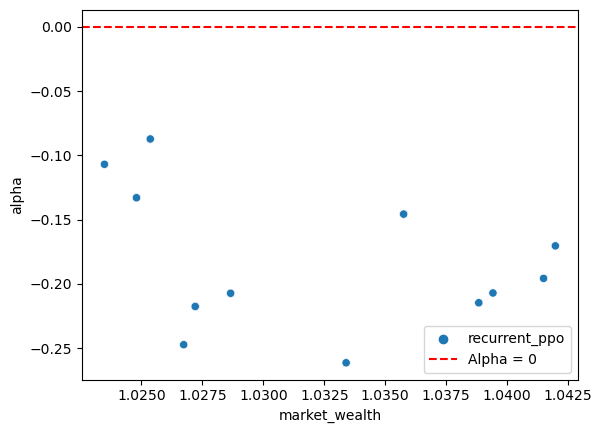

In [95]:

sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='agent')
plt.axhline(0, linestyle='--', color='red', label='Alpha = 0')
plt.legend()
plt.show()

<Axes: xlabel='agent', ylabel='alpha_ratio'>

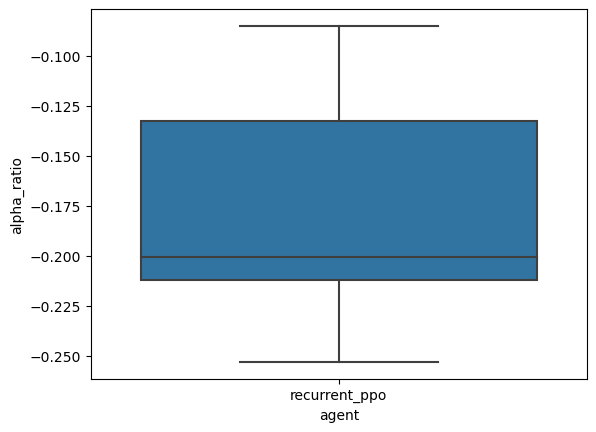

In [96]:
ppo_agent_df['alpha_ratio'] = ppo_agent_df['alpha'] / np.abs(ppo_agent_df['market_wealth'] + 1e-8)
sns.boxplot(data=ppo_agent_df, x='agent', y='alpha_ratio')

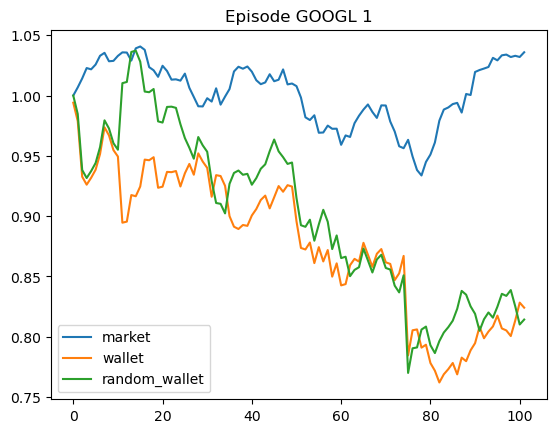

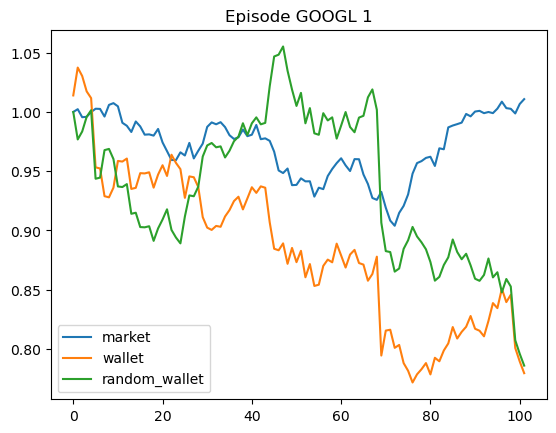

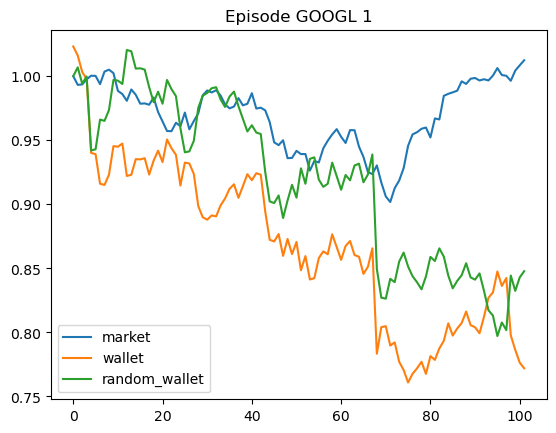

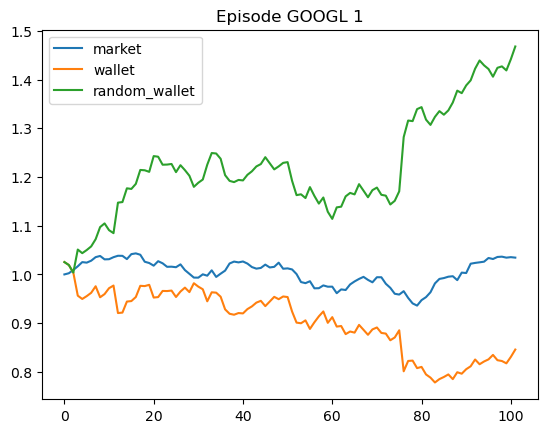

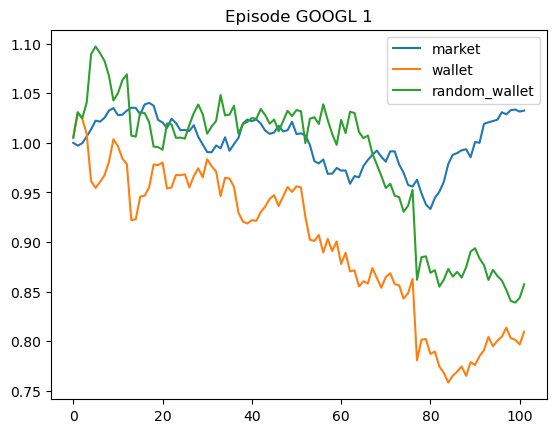

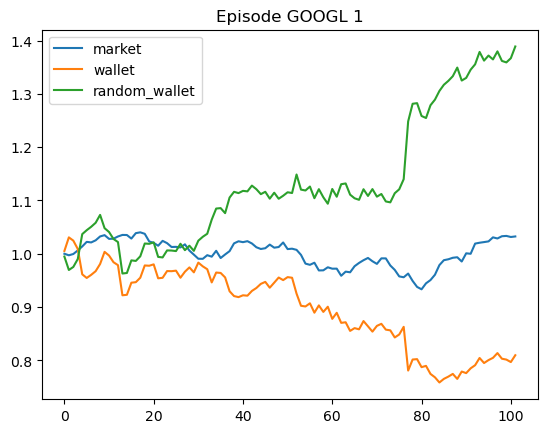

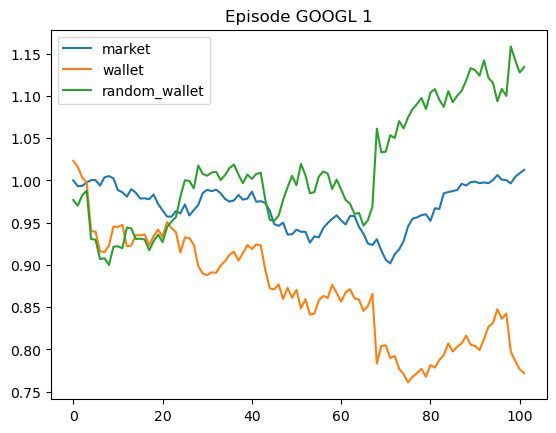

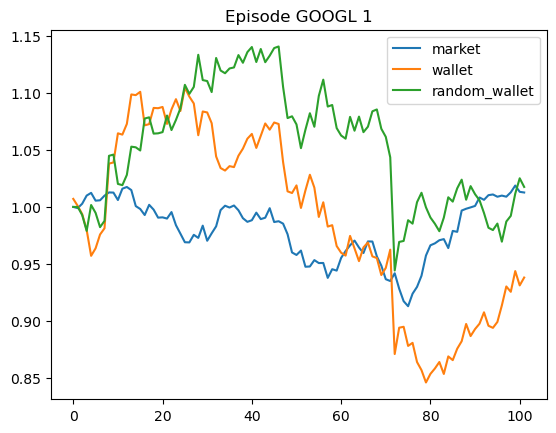

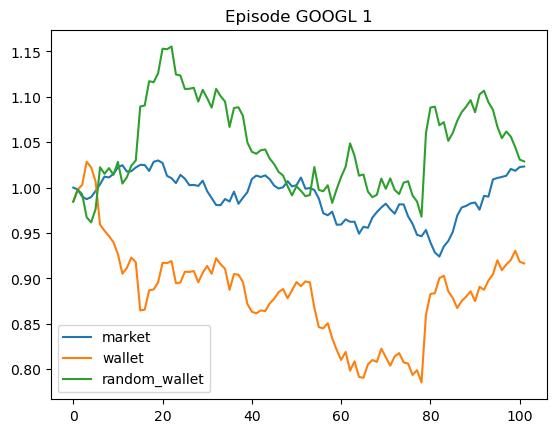

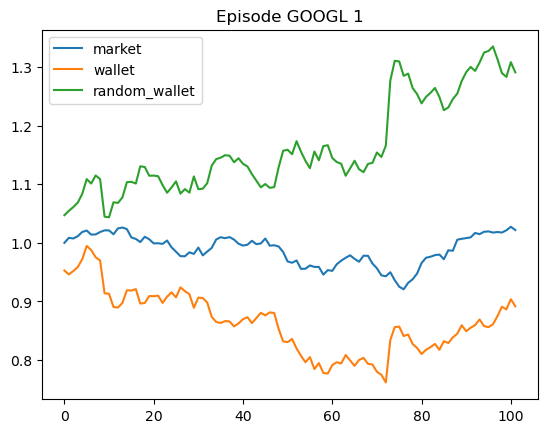

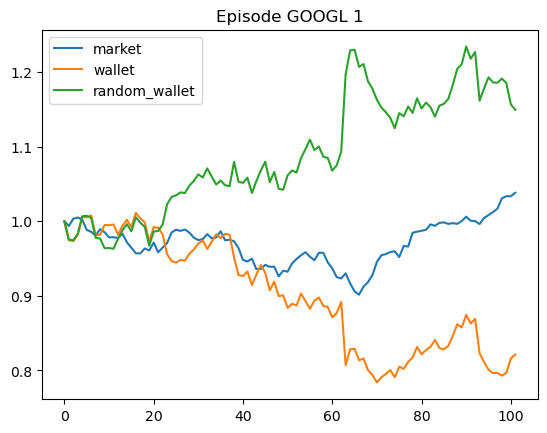

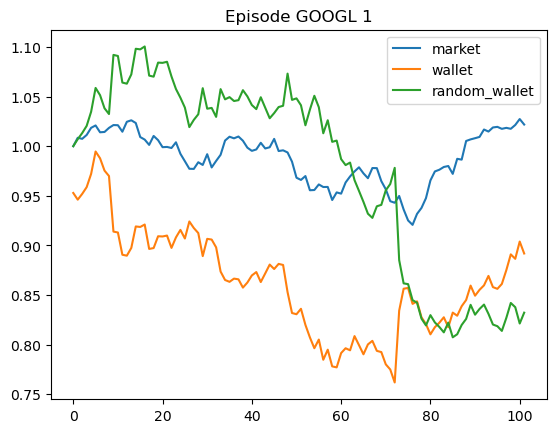

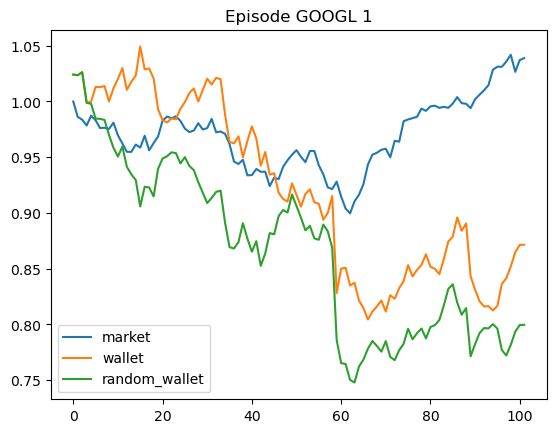

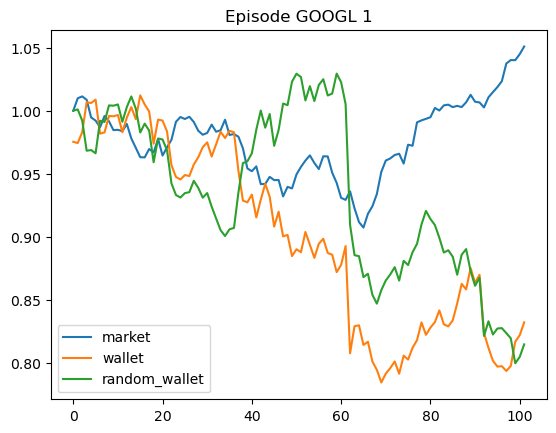

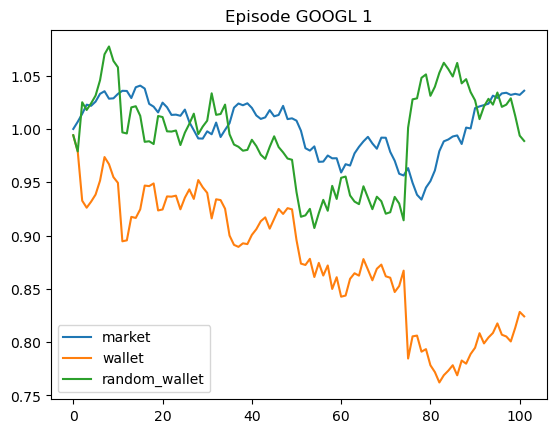

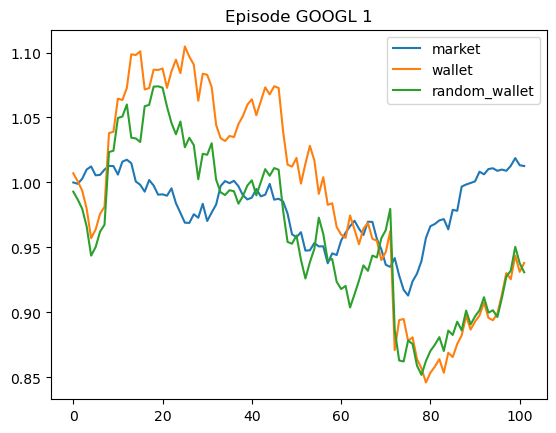

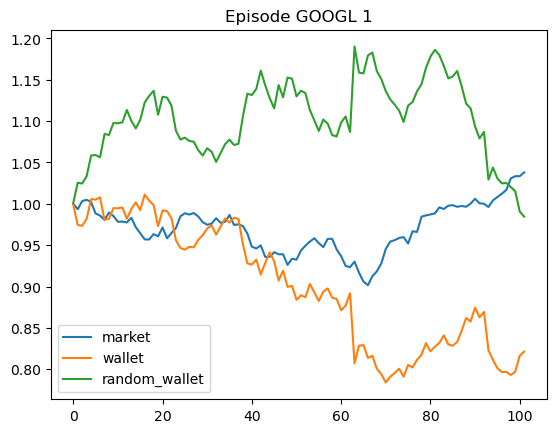

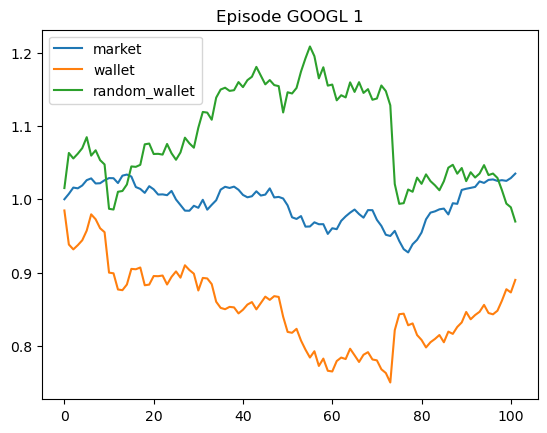

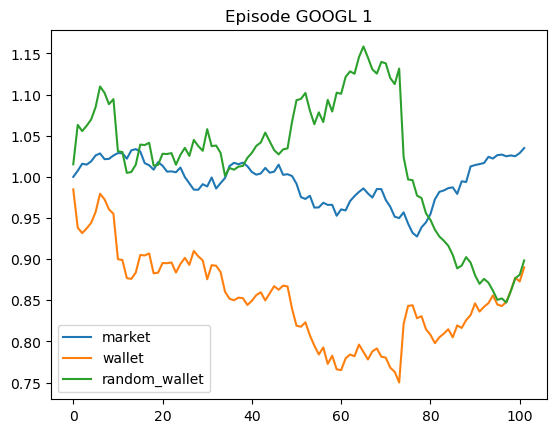

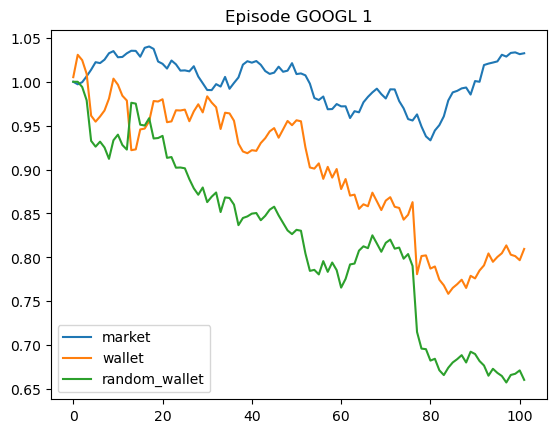

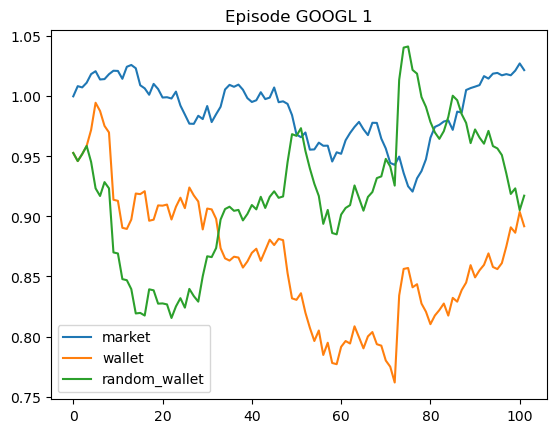

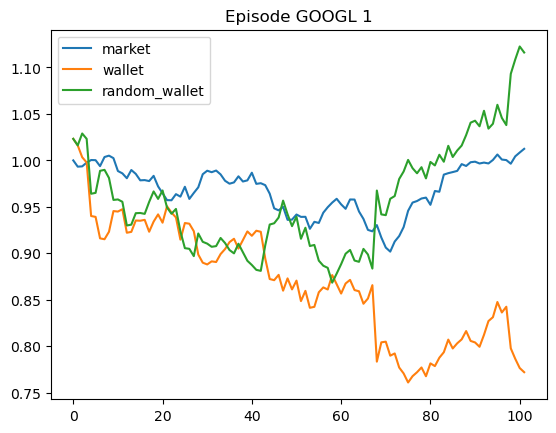

In [99]:
for i in range(len(ppo_agent_infos)):
    bot_df= pd.DataFrame({"market":[0]+ppo_agent_infos[i]["market_returns"].tolist(),"wallet":ppo_agent_infos[i]["returns"],"random_wallet":random_agent_infos[i]["returns"]})
    bot_df['wallet']= bot_df['wallet']+1
    bot_df['random_wallet']= bot_df['random_wallet']+1
    bot_df['market']= bot_df['market']+1
    bot_df['wallet']= bot_df['wallet'].cumprod()
    bot_df['market']= bot_df['market'].cumprod()
    bot_df['random_wallet']= bot_df['random_wallet'].cumprod()
    bot_df.plot(title="Episode "+ppo_agent_infos[i]["ticker"]+' '+str(len(ppo_agent_infos[i]["tickers"])))